In [2]:
import os
import sys
import csv
import json
from datetime import datetime, timedelta
from collections import Counter, OrderedDict
import random
import pandas as pd
import numpy as np
from itertools import chain
import tqdm

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(seed=42)

In [4]:
project_path = os.getcwd()
data_path = project_path
print('project_path:', project_path)
print('data_path:', data_path)

project_path: /Volumes/GoogleDrive-113362305838314413320/My Drive/Research/Project/Meta_Transfer/Temporal_Robustness/data/MIMIC
data_path: /Volumes/GoogleDrive-113362305838314413320/My Drive/Research/Project/Meta_Transfer/Temporal_Robustness/data/MIMIC


Download the corresponding tables here https://physionet.org/content/mimiciv/1.0/ (from "core" and "hosp" modules)

- patients.csv
- admissions.csv
- diagnoses_icd.csv
- procedures_icd.csv

Decompress the files and put them under `[data_path]/raw/mimic4`

Reference: https://mimic.mit.edu/docs/iv/

## patients

In [5]:
patients = pd.read_csv(os.path.join(data_path, 'raw/mimic4/patients.csv'))
print(patients.shape)
patients.head()

(382278, 6)


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000048,F,23,2126,2008 - 2010,NaN
1,10002723,F,0,2128,2017 - 2019,NaN
2,10003939,M,0,2184,2008 - 2010,NaN
3,10004222,M,0,2161,2014 - 2016,NaN
4,10005325,F,0,2154,2011 - 2013,NaN


In [6]:
patients.subject_id.nunique()

382278

In [7]:
patients.groupby('anchor_year_group').subject_id.nunique()

anchor_year_group
2008 - 2010    118616
2011 - 2013     92317
2014 - 2016     88488
2017 - 2019     82857
Name: subject_id, dtype: int64

In [8]:
def sample_year(anchor_year_group):
    year_min = int(anchor_year_group[:4])
    year_max = int(anchor_year_group[-4:])
    assert year_max - year_min == 2
    return random.randint(year_min, year_max)

sample_year('2008 - 2010')

2010

In [9]:
patients['real_anchor_year_sample'] = patients.anchor_year_group.apply(lambda x: sample_year(x))
patients.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,real_anchor_year_sample
0,10000048,F,23,2126,2008 - 2010,NaN,2008
1,10002723,F,0,2128,2017 - 2019,NaN,2017
2,10003939,M,0,2184,2008 - 2010,NaN,2010
3,10004222,M,0,2161,2014 - 2016,NaN,2015
4,10005325,F,0,2154,2011 - 2013,NaN,2011


In [10]:
patients = patients[['subject_id', 'gender', 'anchor_age', 'anchor_year', 'real_anchor_year_sample']]
patients.head()

,subject_id,gender,anchor_age,anchor_year,real_anchor_year_sample
0,10000048,F,23,2126,2008
1,10002723,F,0,2128,2017
2,10003939,M,0,2184,2010
3,10004222,M,0,2161,2015
4,10005325,F,0,2154,2011


In [11]:
patients = patients.dropna().reset_index(drop=True)
print(patients.shape)
patients.head()

(382278, 5)


,subject_id,gender,anchor_age,anchor_year,real_anchor_year_sample
0,10000048,F,23,2126,2008
1,10002723,F,0,2128,2017
2,10003939,M,0,2184,2010
3,10004222,M,0,2161,2015
4,10005325,F,0,2154,2011


## admissions

In [14]:
admissions = pd.read_csv(os.path.join(data_path, 'raw/mimic4/admissions.csv'))
print(admissions.shape)
admissions.head()

(523740, 15)


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
0,14679932,21038362,2139-09-26 14:16:00,2139-09-28 11:30:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,SINGLE,UNKNOWN,NaN,NaN,0
1,15585972,24941086,2123-10-07 23:56:00,2123-10-12 11:22:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,WHITE,NaN,NaN,0
2,11989120,21965160,2147-01-14 09:00:00,2147-01-17 14:25:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,UNKNOWN,NaN,NaN,0
3,17817079,24709883,2165-12-27 17:33:00,2165-12-31 21:18:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,OTHER,NaN,NaN,0
4,15078341,23272159,2122-08-28 08:48:00,2122-08-30 12:32:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,BLACK/AFRICAN AMERICAN,NaN,NaN,0


In [15]:
admissions.hadm_id.nunique()

523740

In [16]:
admissions['admittime'] = pd.to_datetime(admissions['admittime']).dt.date
admissions.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,ethnicity,edregtime,edouttime,hospital_expire_flag
0,14679932,21038362,2139-09-26,2139-09-28 11:30:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,SINGLE,UNKNOWN,NaN,NaN,0
1,15585972,24941086,2123-10-07,2123-10-12 11:22:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,WHITE,NaN,NaN,0
2,11989120,21965160,2147-01-14,2147-01-17 14:25:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,UNKNOWN,NaN,NaN,0
3,17817079,24709883,2165-12-27,2165-12-31 21:18:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,OTHER,NaN,NaN,0
4,15078341,23272159,2122-08-28,2122-08-30 12:32:00,NaN,ELECTIVE,NaN,HOME,Other,ENGLISH,NaN,BLACK/AFRICAN AMERICAN,NaN,NaN,0


In [17]:
admissions = admissions[['subject_id', 'hadm_id', 'ethnicity', 'admittime', 'hospital_expire_flag']]
print(admissions.shape)

(523740, 5)


In [18]:
admissions = admissions.dropna()
print(admissions.shape)
admissions.head()

(523740, 5)


,subject_id,hadm_id,ethnicity,admittime,hospital_expire_flag
0,14679932,21038362,UNKNOWN,2139-09-26,0
1,15585972,24941086,WHITE,2123-10-07,0
2,11989120,21965160,UNKNOWN,2147-01-14,0
3,17817079,24709883,OTHER,2165-12-27,0
4,15078341,23272159,BLACK/AFRICAN AMERICAN,2122-08-28,0


mortality label

In [19]:
admissions['mortality'] = admissions.hospital_expire_flag
admissions.head()

,subject_id,hadm_id,ethnicity,admittime,hospital_expire_flag,mortality
0,14679932,21038362,UNKNOWN,2139-09-26,0,0
1,15585972,24941086,WHITE,2123-10-07,0,0
2,11989120,21965160,UNKNOWN,2147-01-14,0,0
3,17817079,24709883,OTHER,2165-12-27,0,0
4,15078341,23272159,BLACK/AFRICAN AMERICAN,2122-08-28,0,0


readmission label

In [20]:
admissions = admissions.sort_values(by=['subject_id', 'hadm_id', 'admittime'])
admissions['next_row_subject_id'] = admissions.subject_id.shift(-1)
admissions['next_row_admittime'] = admissions.admittime.shift(-1)
admissions.head()

,subject_id,hadm_id,ethnicity,admittime,hospital_expire_flag,mortality,next_row_subject_id,next_row_admittime
266356,10000019,25058216,WHITE,2129-05-21,0,0,10000032.0,2180-05-06
434288,10000032,22595853,WHITE,2180-05-06,0,0,10000032.0,2180-06-26
446284,10000032,22841357,WHITE,2180-06-26,0,0,10000032.0,2180-08-05
453525,10000032,25742920,WHITE,2180-08-05,0,0,10000032.0,2180-07-23
427806,10000032,29079034,WHITE,2180-07-23,0,0,10000044.0,2150-09-30


In [21]:
def assign_readmission_label(row):
    curr_subject_id = row.subject_id
    curr_admittime = row.admittime
    
    next_row_subject_id = row.next_row_subject_id
    next_row_admittime = row.next_row_admittime
    
    if curr_subject_id != next_row_subject_id:
        label = 0
    elif (next_row_admittime - curr_admittime).days > 15:
        label = 0
    else:
        label = 1
    
    return label
    
admissions['readmission'] = admissions.apply(lambda x: assign_readmission_label(x), axis=1)
admissions.head()

,subject_id,hadm_id,ethnicity,admittime,hospital_expire_flag,mortality,next_row_subject_id,next_row_admittime,readmission
266356,10000019,25058216,WHITE,2129-05-21,0,0,10000032.0,2180-05-06,0
434288,10000032,22595853,WHITE,2180-05-06,0,0,10000032.0,2180-06-26,0
446284,10000032,22841357,WHITE,2180-06-26,0,0,10000032.0,2180-08-05,0
453525,10000032,25742920,WHITE,2180-08-05,0,0,10000032.0,2180-07-23,1
427806,10000032,29079034,WHITE,2180-07-23,0,0,10000044.0,2150-09-30,0


In [22]:
admissions = admissions[['subject_id', 'hadm_id', 'ethnicity', 'admittime', 'mortality', 'readmission']]
admissions = admissions.dropna().reset_index(drop=True)
print(admissions.shape)
admissions.head()

(523740, 6)


,subject_id,hadm_id,ethnicity,admittime,mortality,readmission
0,10000019,25058216,WHITE,2129-05-21,0,0
1,10000032,22595853,WHITE,2180-05-06,0,0
2,10000032,22841357,WHITE,2180-06-26,0,0
3,10000032,25742920,WHITE,2180-08-05,0,1
4,10000032,29079034,WHITE,2180-07-23,0,0


## diagnoses_icd

In [24]:
diagnoses_icd = pd.read_csv(os.path.join(data_path, 'raw/mimic4/diagnoses_icd.csv'))
print(diagnoses_icd.shape)
diagnoses_icd.head()

(5280351, 5)


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,15734973,20475282,3,2825,9
1,15734973,20475282,2,V0251,9
2,15734973,20475282,5,V270,9
3,15734973,20475282,1,64891,9
4,15734973,20475282,4,66481,9


In [25]:
diagnoses_icd = diagnoses_icd.dropna()
print(diagnoses_icd.shape)

(5280351, 5)


In [26]:
diagnoses_icd = diagnoses_icd.drop_duplicates()
print(diagnoses_icd.shape)

(5280351, 5)


In [27]:
diagnoses_icd = diagnoses_icd.sort_values(by=['subject_id', 'hadm_id', 'seq_num'])
diagnoses_icd.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
368080,10000019,25058216,1,V3000,9
368079,10000019,25058216,2,V053,9
368082,10000019,25058216,3,V502,9
368081,10000019,25058216,4,V290,9
2576415,10000032,22595853,1,5723,9


In [28]:
diagnoses_icd.icd_version.value_counts()

9     3090370
10    2189981
Name: icd_version, dtype: int64

In [29]:
diagnoses_icd['icd_code'] = diagnoses_icd.apply(lambda x: f'ICD{x.icd_version}_{x.icd_code}', axis=1)
diagnoses_icd.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
368080,10000019,25058216,1,ICD9_V3000,9
368079,10000019,25058216,2,ICD9_V053,9
368082,10000019,25058216,3,ICD9_V502,9
368081,10000019,25058216,4,ICD9_V290,9
2576415,10000032,22595853,1,ICD9_5723,9


In [30]:
def diag_icd9_to_3digit(icd9):
    if icd9.startswith('E'):
        if len(icd9) >= 4: 
            return icd9[:4]
        else:
            print(icd9)
            return icd9
    else:
        if len(icd9) >= 3: 
            return icd9[:3]
        else:
            print(icd9)
            return icd9
        
        
def diag_icd10_to_3digit(icd10):
    if len(icd10) >= 3: 
        return icd10[:3]
    else:
        print(icd10)
        return icd10
    
    
def diag_icd_to_3digit(icd):
    if icd[:4] == 'ICD9':
        return 'ICD9_' + diag_icd9_to_3digit(icd[5:])
    elif icd[:5] == 'ICD10':
        return 'ICD10_' + diag_icd10_to_3digit(icd[6:])
    else:
        raise
    
        
print(diag_icd9_to_3digit('V463'))
print(diag_icd10_to_3digit('N2889'))
print(diag_icd_to_3digit('ICD10_M00871'))
print(diag_icd_to_3digit('ICD9_E8841'))

V46
N28
ICD10_M00
ICD9_E884


In [31]:
diagnoses_icd['icd_3digit'] = diagnoses_icd.icd_code.apply(lambda x: diag_icd_to_3digit(x))
diagnoses_icd.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,icd_3digit
368080,10000019,25058216,1,ICD9_V3000,9,ICD9_V30
368079,10000019,25058216,2,ICD9_V053,9,ICD9_V05
368082,10000019,25058216,3,ICD9_V502,9,ICD9_V50
368081,10000019,25058216,4,ICD9_V290,9,ICD9_V29
2576415,10000032,22595853,1,ICD9_5723,9,ICD9_572


In [32]:
print(diagnoses_icd.icd_3digit.nunique())

2898


In [33]:
def list_join(lst):
    return ' <sep> '.join(lst)

list_join(['00168007011', '00409915701'])

'00168007011 <sep> 00409915701'

In [34]:
diagnoses_icd = diagnoses_icd.groupby(['subject_id', 'hadm_id']).agg({'icd_3digit': list_join}).reset_index()
diagnoses_icd.head()

,subject_id,hadm_id,icd_3digit
0,10000019,25058216,ICD9_V30 <sep> ICD9_V05 <sep> ICD9_V50 <sep> I...
1,10000032,22595853,ICD9_572 <sep> ICD9_789 <sep> ICD9_571 <sep> I...
2,10000032,22841357,ICD9_070 <sep> ICD9_789 <sep> ICD9_287 <sep> I...
3,10000032,25742920,ICD9_070 <sep> ICD9_789 <sep> ICD9_V46 <sep> I...
4,10000032,29079034,ICD9_458 <sep> ICD9_070 <sep> ICD9_799 <sep> I...


In [35]:
diagnoses_icd = diagnoses_icd.rename(columns={'icd_3digit': 'diagnoses'})
diagnoses_icd.head()

,subject_id,hadm_id,diagnoses
0,10000019,25058216,ICD9_V30 <sep> ICD9_V05 <sep> ICD9_V50 <sep> I...
1,10000032,22595853,ICD9_572 <sep> ICD9_789 <sep> ICD9_571 <sep> I...
2,10000032,22841357,ICD9_070 <sep> ICD9_789 <sep> ICD9_287 <sep> I...
3,10000032,25742920,ICD9_070 <sep> ICD9_789 <sep> ICD9_V46 <sep> I...
4,10000032,29079034,ICD9_458 <sep> ICD9_070 <sep> ICD9_799 <sep> I...


## procedures_icd

In [36]:
procedures_icd = pd.read_csv(os.path.join(data_path, 'raw/mimic4/procedures_icd.csv'))
print(procedures_icd.shape)
procedures_icd.head()

(779625, 6)


,subject_id,hadm_id,seq_num,chartdate,icd_code,icd_version
0,10287061,27485182,1,2124-08-22,7569,9
1,13135573,22286210,3,2187-05-30,7309,9
2,13135573,22286210,1,2187-05-30,7569,9
3,13135573,22286210,2,2187-05-30,734,9
4,12646116,24154012,2,2115-01-13,734,9


In [37]:
procedures_icd = procedures_icd.dropna()
print(procedures_icd.shape)

(779625, 6)


In [38]:
procedures_icd = procedures_icd.drop_duplicates()
print(procedures_icd.shape)

(779625, 6)


In [39]:
procedures_icd = procedures_icd.sort_values(by=['subject_id', 'hadm_id', 'seq_num'])
procedures_icd.head()

,subject_id,hadm_id,seq_num,chartdate,icd_code,icd_version
401312,10000019,25058216,1,2129-05-22,640,9
641529,10000032,22595853,1,2180-05-07,5491,9
642632,10000032,22841357,1,2180-06-27,5491,9
643412,10000032,25742920,1,2180-08-06,5491,9
214668,10000068,25022803,1,2160-03-03,8938,9


In [40]:
procedures_icd.icd_version.value_counts()

9     521037
10    258588
Name: icd_version, dtype: int64

In [41]:
procedures_icd['icd_code'] = procedures_icd.apply(lambda x: f'ICD{x.icd_version}_{x.icd_code}', axis=1)
procedures_icd.head()

,subject_id,hadm_id,seq_num,chartdate,icd_code,icd_version
401312,10000019,25058216,1,2129-05-22,ICD9_640,9
641529,10000032,22595853,1,2180-05-07,ICD9_5491,9
642632,10000032,22841357,1,2180-06-27,ICD9_5491,9
643412,10000032,25742920,1,2180-08-06,ICD9_5491,9
214668,10000068,25022803,1,2160-03-03,ICD9_8938,9


In [42]:
print(procedures_icd.icd_code.nunique())

13016


In [43]:
def proc_icd9_to_3digit(icd9):
    if len(icd9) >= 3: 
        return icd9[:3]
    else:
        print(icd9)
        return icd9
    
    
def proc_icd10_to_3digit(icd10):
    if len(icd10) >= 3: 
        return icd10[:3]
    else:
        print(icd10)
        return icd10
    
    
def proc_icd_to_3digit(icd):
    if icd[:4] == 'ICD9':
        return 'ICD9_' + proc_icd9_to_3digit(icd[5:])
    elif icd[:5] == 'ICD10':
        return 'ICD10_' + proc_icd10_to_3digit(icd[6:])
    else:
        raise
            
        
print(proc_icd9_to_3digit('0601'))
print(proc_icd10_to_3digit('0GTH0ZZ'))
print(proc_icd_to_3digit('ICD9_8584'))
print(proc_icd_to_3digit('ICD10_D7021ZZ'))

060
0GT
ICD9_858
ICD10_D70


In [44]:
procedures_icd['icd_3digit'] = procedures_icd.icd_code.apply(lambda x: proc_icd_to_3digit(x))
procedures_icd.head()

,subject_id,hadm_id,seq_num,chartdate,icd_code,icd_version,icd_3digit
401312,10000019,25058216,1,2129-05-22,ICD9_640,9,ICD9_640
641529,10000032,22595853,1,2180-05-07,ICD9_5491,9,ICD9_549
642632,10000032,22841357,1,2180-06-27,ICD9_5491,9,ICD9_549
643412,10000032,25742920,1,2180-08-06,ICD9_5491,9,ICD9_549
214668,10000068,25022803,1,2160-03-03,ICD9_8938,9,ICD9_893


In [45]:
procedures_icd = procedures_icd.groupby(['subject_id', 'hadm_id']).agg({'icd_3digit': list_join}).reset_index()
procedures_icd.head()

,subject_id,hadm_id,icd_3digit
0,10000019,25058216,ICD9_640
1,10000032,22595853,ICD9_549
2,10000032,22841357,ICD9_549
3,10000032,25742920,ICD9_549
4,10000068,25022803,ICD9_893


In [46]:
procedures_icd = procedures_icd.rename(columns={'icd_3digit': 'procedure'})
procedures_icd.head()

,subject_id,hadm_id,procedure
0,10000019,25058216,ICD9_640
1,10000032,22595853,ICD9_549
2,10000032,22841357,ICD9_549
3,10000032,25742920,ICD9_549
4,10000068,25022803,ICD9_893


## merge

In [47]:
df = admissions.merge(patients, on='subject_id', how='inner')
df.head()

,subject_id,hadm_id,ethnicity,admittime,mortality,readmission,gender,anchor_age,anchor_year,real_anchor_year_sample
0,10000019,25058216,WHITE,2129-05-21,0,0,M,0,2129,2009
1,10000032,22595853,WHITE,2180-05-06,0,0,F,52,2180,2014
2,10000032,22841357,WHITE,2180-06-26,0,0,F,52,2180,2014
3,10000032,25742920,WHITE,2180-08-05,0,1,F,52,2180,2014
4,10000032,29079034,WHITE,2180-07-23,0,0,F,52,2180,2014


In [48]:
df['real_admit_year'] = df.apply(lambda x: x.admittime.year - x.anchor_year + x.real_anchor_year_sample, axis=1)
df['age'] = df.apply(lambda x: x.admittime.year - x.anchor_year + x.anchor_age, axis=1)
df.head()

,subject_id,hadm_id,ethnicity,admittime,mortality,readmission,gender,anchor_age,anchor_year,real_anchor_year_sample,real_admit_year,age
0,10000019,25058216,WHITE,2129-05-21,0,0,M,0,2129,2009,2009,0
1,10000032,22595853,WHITE,2180-05-06,0,0,F,52,2180,2014,2014,52
2,10000032,22841357,WHITE,2180-06-26,0,0,F,52,2180,2014,2014,52
3,10000032,25742920,WHITE,2180-08-05,0,1,F,52,2180,2014,2014,52
4,10000032,29079034,WHITE,2180-07-23,0,0,F,52,2180,2014,2014,52


In [49]:
df = df[['subject_id', 'hadm_id', 
         'admittime', 'real_admit_year', 
         'age', 'gender', 'ethnicity',
         'mortality', 'readmission']]
df.head()

,subject_id,hadm_id,admittime,real_admit_year,age,gender,ethnicity,mortality,readmission
0,10000019,25058216,2129-05-21,2009,0,M,WHITE,0,0
1,10000032,22595853,2180-05-06,2014,52,F,WHITE,0,0
2,10000032,22841357,2180-06-26,2014,52,F,WHITE,0,0
3,10000032,25742920,2180-08-05,2014,52,F,WHITE,0,1
4,10000032,29079034,2180-07-23,2014,52,F,WHITE,0,0


In [52]:
df = df.merge(diagnoses_icd, on=['subject_id', 'hadm_id'], how='inner')
df = df.merge(procedures_icd, on=['subject_id', 'hadm_id'], how='inner')
df.head()
df.to_csv('./data_preprocessed.csv')

In [47]:
assert df.isnull().any().any() == False

## cohort selection

In [48]:
df.shape

(276848, 11)

age

<AxesSubplot:ylabel='Frequency'>

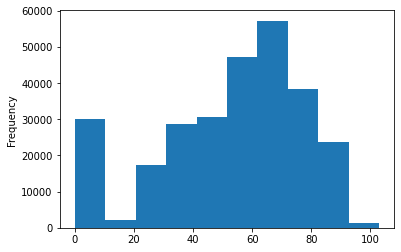

In [49]:
df.age.plot.hist(bins=10)

In [50]:
df = df[df.age.apply(lambda x: (x >= 18) & (x <= 89))]
df.shape

(239246, 11)

## save

In [51]:
directory = os.path.join(data_path, 'processed/mimic4/')
if not os.path.exists(directory):
    os.makedirs(directory)
        
df.to_csv(os.path.join(data_path, 'processed/mimic4/data.csv'), index=False)

## statistics

In [60]:
print(df.mortality.mean())
df.mortality.value_counts()

0.02918753082601172


0    232263
1      6983
Name: mortality, dtype: int64

In [63]:
print(df.readmission.mean())
df.readmission.value_counts()

0.27998378238298655


0    172261
1     66985
Name: readmission, dtype: int64

<AxesSubplot:>

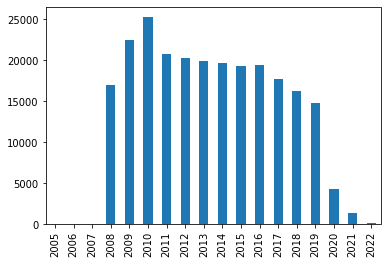

In [64]:
df.real_admit_year.value_counts().sort_index().plot(kind='bar')

In [71]:
df.groupby('real_admit_year').agg(total_admissions=('hadm_id', 'nunique'), 
                                  readmission_date=('readmission', 'mean'),
                                  mortality_date=('mortality', 'mean'))

,total_admissions,readmission_date,mortality_date
real_admit_year,,,
2005,5,0.000000,0.000000
2006,4,0.000000,0.000000
2007,17,0.000000,0.000000
2008,17052,0.118696,0.023223
2009,22484,0.168209,0.022371
2010,25261,0.199715,0.022881
2011,20763,0.261427,0.027501
2012,20334,0.277024,0.026950
2013,19976,0.280687,0.026982
